# Discovery of Higgs Boson
In this assignment, we'll use data directly from the LHC (Large Hadron Collider) along with Monte-Carlo (MC) simulations to claim the discovery of the Higgs Boson! Please make sure to use the seed 6372 for both PyTorch and Numpy.

<b> Due Date: 05/03/2024 11:59pm</b> <br>
<b> Submission: Output this file as both .ipynb and .pdf files and zip them before uploading to Gradescope</b> <br>

In [303]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest
import util


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Important for re-production
torch.manual_seed(6372)
np.random.seed(6372)


# Problem Setup

At the LHC, protons are accelerated to incredible speeds before they are collided. The collision results in sub-atomic particles that go through multiple phases of decay. These final decay products are the observables by the LHC detectors. Thus, the Higgs Boson is not observed directly but indirectly through its decay products. Our job is to conclude the existence of the Higgs Boson by observing such decay products. However, things aren't that simple. There are two obstacles to overcome.

First, data generated directly from LHC collisions is huge (on the order of billions of entries). Thus, there has to be some filtering. The first type of filtering is online filtering. This happens automatically by LHC detectors to discard any events/collisions that aren't of primary importance for study, which reduces the size of data by few orders of magnitude. After online filtering, there comes off-line filtering. This filtering happens through the use of sophisticated knowledge of theoritical physics and is typically conducted by humans. <b>The data we have for this assignment comes after these two stages of filtering and is only ~ 500 entries</b>.

Second, even after such filtering, we have confounding decay processes that produce the same final decay products as the Higgs decay! In other words, it is impossible to conclude the Higgs Boson discovery by only looking at the <i>types</i> of decay particles. We then have to look at other properties like kinetic energy, momentum etc... However, such properties are continuous in nature and observing any one value doesn't say much. The only remaining solution, then, is to study the statistical properties of such observations.

So how does statistics help us "discover" the Higgs Boson? Through hypothesis testing!

Luckily, even with confounding processes producing identical types of decay particles, theoretical physics describes different statistical distributions for products coming from Higgs vs. products coming from background. We will denote distribution of data coming Higgs by $Q$ and distribution of data coming from background by $P_0$. To make things more complicated, there is more than one background process. So $P_0$ can only be discribed as a <i>mixture</i> of multiple background processes. In other words, 
$$
P_0 = \sum_i a_i P_{0, i}
$$
where $P_{0, i}$ is the background distribution generated from process $i$, and $a_i$ is the mixing ratio.

Finally, $Q, P_{0, i}$ are not given to us explicitly. In other words, we don't have closed-form expressions for their CDF/PDF. We can only sample from $Q, P_{0, i}$ through Monte-Carlo simulations. We will use these Monte-Carlo samples to compare the real experimental data recorded at the LHC with what the data should be under the null hypothesis. 

<b>1. Data Loading</b>

(1a) (0.5 pt) Read the experimental data from the LHC. Use <b>load_expr_data()</b> function provided in utils.py. Store the dataframe object in the variable <b>data</b>

In [304]:
data = util.load_expr_data()

(1b) (0.5 pt) Print the size of the data and column names. 

In [305]:
print("Size of the data: ", data.shape)
print("Column names: ", data.columns)

Size of the data:  (495, 38)
Column names:  Index(['Unnamed: 0', 'Run', 'Event', 'PID1', 'Q1', 'E1', 'px1', 'py1', 'pz1',
       'eta1', 'phi1', 'PID2', 'Q2', 'E2', 'px2', 'py2', 'pz2', 'eta2', 'phi2',
       'PID3', 'Q3', 'E3', 'px3', 'py3', 'pz3', 'eta3', 'phi3', 'PID4', 'Q4',
       'E4', 'px4', 'py4', 'pz4', 'eta4', 'phi4', 'mass', 'mass_z1',
       'mass_z2'],
      dtype='object')


(1c) (0.5 pt) Read the simuated MC data. Use the <b>load_processes()</b> function provided in utils.py. Store the list of dataframe objects in a variable <b>mc_processes</b>. Note that the first element of the of the list is the MC Higgs process. The rest are MC background processes.

In [306]:
mc_processes = util.load_processes()

(1d) (0.5 pt) Print the number of MC background processes. Print the size of the Higgs MC process as well as each of the MC background processes. 

In [307]:
num_background_processes = len(mc_processes) - 1
higgs_size = len(mc_processes[0])

print("number of MC background processes:", num_background_processes)
print("size of the Higgs MC process:", higgs_size)

background_sizes = [len(process) for process in mc_processes[1:]]
for i, size in enumerate(background_sizes):
    print(f"MC background process size {i+1}:", size)

number of MC background processes: 6
size of the Higgs MC process: 37393
MC background process size 1: 164425
MC background process size 2: 106147
MC background process size 3: 85903
MC background process size 4: 4
MC background process size 5: 8
MC background process size 6: 2


(1e) (0.5 pt) Choose any MC process and print its column names.

In [308]:
print("Column names of the first MC process:",mc_processes[1].columns)

Column names of the first MC process: Index(['Unnamed: 0', 'Run', 'Event', 'PID1', 'Q1', 'E1', 'px1', 'py1', 'pz1',
       'eta1', 'phi1', 'PID2', 'Q2', 'E2', 'px2', 'py2', 'pz2', 'eta2', 'phi2',
       'PID3', 'Q3', 'E3', 'px3', 'py3', 'pz3', 'eta3', 'phi3', 'PID4', 'Q4',
       'E4', 'px4', 'py4', 'pz4', 'eta4', 'phi4', 'mass', 'mass_z1', 'mass_z2',
       'signal'],
      dtype='object')


(1f) (0.5 pt) Compare MC column names with those of the experimental data. There should be one additional column for the MC processes. What is the meaning of this column? Why can't we have such column in the experimental data?

The extra 'signal' column is relating to the Higgs signal process, and it labels each simulated event as either being signal or background.
Experimental data has a mixture of signal from the higgs and background, so due to unknowability of signal, we can
merely hypothesize the source of any observed signal.

<b>2. Data Munging</b>

(2a) (0.5 pt) Below we have defined two lists. <b>object_cols</b> specifies the categorial features of our data. In our case, it describes the <b>PID</b> (Particle ID). <b>irrelevant_cols</b> describes predictors to be discarded.

You task is to one-hot encode the categorial features and discard the irrelevant features. Use <b>encoder, trim</b> from utils.py. Read the documentation carefully. It should be clear enough for you to use them.

In [309]:
object_cols = ['PID1', 'PID2', 'PID3', 'PID4'] 

# Vanilla
irrelevant_cols = ['Unnamed: 0', 'Run', 'Event', 'Q1', 'Q2', 'Q3', 'Q4', 'mass', 'mass_z1', 'mass_z2']

# your code here
OH_encoder = util.encoder(mc_processes, object_cols)
data, mc_processes = util.trim(OH_encoder, object_cols, irrelevant_cols, mc_processes, data)

<b>Digression on MC Sampling:</b> Recall from the problem setup above that $P_0$ is a mixture of distributions $P_{0, i}$ each with a ratio $a_i$. These ratios describe the relative frequency of each background process in the mixture. Now, MC sampling doesn't only simulate background/higgs collisions. It also simulates the detection process. Because of that, lots of MC generated events won't be detected. Thus, the number of entries for each mc processes dataframe is only a small fraction of the number of MC events generated for that process. For actual numbers of MC events look at <b>nevt_*</b> in util.py. Moreover, the number of MC events for a given process doesn't necessarily match the <i>expected</i> number of events for that process, which is given by <b>luminosity x cross-section</b> (again, look at util.py). Thus, to accurately represent $P_0, Q$, we have to rescale/re-weigh each of the MC processes. 

(2b) (0.5 pt) Create a list <b>weights</b> containing the weights of each of the MC processes. Use <b>compute_weights()</b> in util.py. 

In [310]:
weights = util.compute_weights()

(2c) (0.5 pt) For each of the MC <i>background</i> processes, calculate the sampling frequencies needed to obtain an accurate sample from $P_0$. The sampling frequencies should add up to one. Store these frequencies in a list <b>P0_frequencies</b>. <br>

<b>Hint: </b> Your answer should depend on the sizes of the MC background processes in <b>mc_processes</b>. Also, first elemnt of <b>weights</b> describes the weight of the Higgs process and is irrelevant here.

In [311]:
background_weights = weights[1:]
total_background_weight = sum(background_weights)
P0_frequencies = [weight / total_background_weight for weight in background_weights]
print("sampling frequencies for background processes (P0):", P0_frequencies)

sampling frequencies for background processes (P0): [0.0005345512091282337, 0.0012453005511374687, 0.0005345408682187206, 0.012448711948797233, 0.7520465210134404, 0.23319037440927792]


(2d) (0.5 pt) Use <b>split</b> in util.py to split the data into three partitions <b>train_processes, sim_processes, synth_processes</b>. <b>train_processes</b> is the training MC data we'll use to learn properties/features about $P_0, Q$ (see below). <b>sim_processes</b> will be used to sample from the background distribution $P_0$ using each of the MC background processes. This will used to perform hypothesis testing. In past years, <b>synth_processes</b> was used for the last phase of the project (which will not be the case this year).

In [312]:
train_processes, sim_processes, synth_processes = util.split(mc_processes)

(2e) (0.5 pt) Add a new column <b>weight</b> for each process in <b>train_processes</b>. Use the <b>weights</b> obtained above which correspond one-by-one to the processes in <b>train_processes</b>. These weights will be used to learn about the properties of $Q, P_0$ later-on.

In [314]:
for i in range(len(train_processes)):
    train_processes[i]['weight'] = weights[i] 

<b>3. Fomulating the problem</b>

Recall that $P_0, Q$ represent the background/Higgs data distributions, respectively. Whatever the ground truth is, the observed experimental data is a mixture of both. More precisely, it has a distribution $\pi Q + (1-\pi) P_0$ for some mixing ratio $\pi \in [0, 1]$. 

(3a) (0.5 pt) If our task is to conclude the discovery of the Higgs Boson through hypothesis testing, describe the null hypothesis in words.

Null: The observed experimental data is solely due to background processes and the higgs doesnt contribute to the data.
Alternative: The experimental data has some proportional contribution from the Higgs boson. 

(3b) (0.5 pt) Describe the null/alternative hypotheses mathematically in terms of $\pi$.

H_0: pi = 0 ; H_1: pi !=0

<b>4. Obtaining $\hat{h}$</b>

Recall from the Neyman-Pearson lemma, the uniformily most powerful test uses the statistic 

$$
h^*(x) = \mathrm{log}\Big(\frac{Q(x)}{P_0(x)}\Big).
$$

Hence, it is natural to study $h^*$. Note, however, that we don't have a closed-form expression for $P_0(x), Q(x)$; only samples. Thus, we'll use the following result:

Any classifier trained with cross-entropy loss
should approximate $h^∗(x)$. More precisely, define the log-loss as usual

$$
l(y, p) = y \mathrm{log} \Big(\frac{1}{p}\Big) + (1-y) \mathrm{log}\Big(\frac{1}{1-p}\Big), \;\;\; y\in \{0, 1\}, p\in [0, 1].
$$

Now, given $n_0 = \nu_0 n$ samples with $y_i = 0$ and $X_i \sim P_0$ and $n_1 = \nu_1 n$
samples with $X_i \sim Q$ we have as $n = n_0 + n_1 \rightarrow \infty$:

$$
\mathrm{log}\Big(\frac{\hat{f}_n}{1-\hat{f}_n}\Big)\rightarrow \mathrm{log}\Big(\frac{\nu_1}{\nu_0}\Big) + h^*
$$

where $\hat{f}_n$ is the sigmoid output of the classifier.
If we have $\nu_0 = \nu_1$, then we have $\mathrm{log}\Big(\frac{\hat{f}_n}{1-\hat{f}_n}\Big)$ is approximately $h^*$.

To that end, our choice of the classifier is a neural network. Moreover, we'll use the <b>weights</b> computed above to re-weigh the training samples for the reasons described in <b>Digression on MC Sampling</b>.

(4a) (0.5 pt) Combine all processes in <b>train_processes</b> into a single dataframe <b>X</b>. Pop the <b>weight</b> column from <b>X</b> and store it in a variable <b>training_weights</b>. Pop the <b>signal</b> column from <b>X</b> into a variable <b>Y</b>.

In [317]:
X = pd.concat(train_processes)
training_weights = X.pop('weight')
Y = X.pop('signal')



(4b) (1 pt) Define a PyTorch <b>Dataset</b> class named <b>MyDataset</b> that indexes the samples <b>X[i], Y[i], training_weights[i]</b>. See https://pytorch.org/tutorials/beginner/basics/data_tutorial.html for tutorial.

In [318]:
class MyDataset(Dataset):
    def __init__(self, X, H, training_weights):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.Y = torch.tensor(Y.values, dtype=torch.float32)
        self.training_weights = torch.tensor(training_weights.values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.training_weights[idx]
    
    
dataset = MyDataset(X, Y, training_weights)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

(4c) (1 pt) Define a model <b>MyModel</b> that takes as argument the input dimension and returns a Dense Nueral Network (DNN) with three hidden layers. Each hidden layer has 10 units with ReLU activation. The output layer has a single unit with sigmoid activation. See https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html for tutorial.

In [319]:
class MyModel(nn.Module):
    def __init__(self, input_dim):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x
        
model = MyModel(X.shape[1])
# notice that reduction='none'
criterion = nn.BCELoss(reduction='none')
opt = torch.optim.Adam(model.parameters())

(4d) (2 pts) Construct the model, then fit it to <b>X, Y</b> weighted by <b>training_weights</b> for 10 epochs. See https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html for tutorial. Print the loss for each epoch.

<b>Note: </b> Make sure the loss is decreasing and after 10 epochs of training, the loss is less than half the loss in the first epoch.

In [320]:
for epoch in range(1, 11):
    avg_loss = 0
    for x, y, w in dataloader:
        opt.zero_grad()
        outputs = model(x.float())
        loss = criterion(outputs.squeeze(), y.float())
        loss = (loss * w).mean() 
        loss.backward()
        opt.step()
        avg_loss += loss.item()
    avg_loss /= len(dataloader)
    print(f'epoch = {epoch}, loss = {avg_loss:.2e}')

epoch = 1, loss = 8.25e-03
epoch = 2, loss = 5.88e-03
epoch = 3, loss = 5.25e-03
epoch = 4, loss = 4.97e-03
epoch = 5, loss = 4.75e-03
epoch = 6, loss = 4.61e-03
epoch = 7, loss = 4.29e-03
epoch = 8, loss = 4.51e-03
epoch = 9, loss = 4.15e-03
epoch = 10, loss = 3.88e-03


(4e) (2 pts) Plot the histograms of the predicted probabilities of (1) X with label Y=0, (2) X with label Y=1, and (3) <b>data</b> (the experimental data). Show three histograms in the same plot with transparency=0.2. Remember to show the legends as well.

<b>Hint:</b> transparency can be set by using the argument <b>alpha</b> in the plt.hist function.

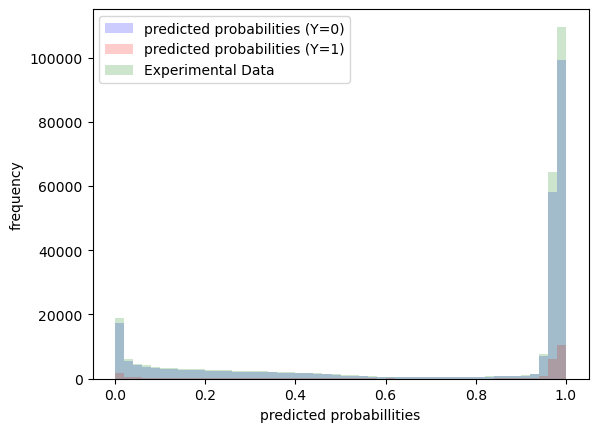

MyModel(
  (fc1): Linear(in_features=40, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
40


In [321]:
def predict_probs(model, dataloader):
    probs = []
    for inputs, _, _ in dataloader:
        outputs = model(inputs.float())
        probs.extend(outputs.squeeze().detach().numpy())
    return probs
    
Y_array = np.array(Y)
predicted_probs_data = predict_probs(model, dataloader)
predicted_probs_Y0 = [predicted_probs_data[i] for i in range(len(predicted_probs_data)) if Y_array[i] == 0]
predicted_probs_Y1 = [predicted_probs_data[i] for i in range(len(predicted_probs_data)) if Y_array[i] == 1]

plt.hist(predicted_probs_Y0, bins=50, alpha=0.2, label='predicted probabilities (Y=0)', color='blue')
plt.hist(predicted_probs_Y1, bins=50, alpha=0.2, label='predicted probabilities (Y=1)', color='red')
plt.hist(predicted_probs_data, bins=50, alpha=0.2, label='Experimental Data', color='green')

plt.xlabel('predicted probabillities')
plt.ylabel('frequency')
plt.legend()

plt.show()
print(model)
print(X.shape[1])

(4f) (0.5 pt) What can you guess from looking at the histograms?

That although faint, there is a predicted likelihood that we can classify some of the proportion of the data to Higgs Boson signal.

From the discussion above, define

$$
\hat{h} := \mathrm{log}\Big(\frac{\hat{f}_n}{1-\hat{f}_n}\Big)
$$

which will act as an approximation of $h^*$.

<b>Evaluating $\hat{h}$</b>

(4g) (1 pt) Argue that $\hat{h}$ can be obtained from the trained DNN above but with replacing the sigmoid activation with a linear activation (i.e. $f(x) = x)$

By doing so, we will not be getting probabilities of classification. Rather, we could get a continuous value not necessarily bounded in 0 to 1.
So this linear activation would represent the log-odds ratio approximation (logit is inverse of sigmoid) of h*(x).

(4h) (3 pts) Re-write the <b>MyModel</b> class to remove the sigmoid activation. Then, train it on <b>X, Y</b> weighted by <b>training_weights</b> for 10 epochs.

In [322]:
class MyModel(nn.Module):
    def __init__(self, input_dim):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = MyModel(X.shape[1])
criterion = nn.BCEWithLogitsLoss(reduction='none')
opt = torch.optim.Adam(model.parameters())

In [323]:
for epoch in range(1, 11):
    avg_loss = 0
    for x, y, w in dataloader:
        opt.zero_grad()
        outputs = model(x.float())
        loss = criterion(outputs.squeeze(), y.float())
        loss = torch.mean(loss * w.view(-1, 1))
        loss.backward()
        opt.step()
        
        avg_loss += loss.item()
    avg_loss /= len(dataloader)
    print(f'epoch = {epoch}, loss = {avg_loss:.2e}')

epoch = 1, loss = 4.64e-02
epoch = 2, loss = 4.33e-02
epoch = 3, loss = 4.27e-02
epoch = 4, loss = 4.10e-02
epoch = 5, loss = 3.12e-02
epoch = 6, loss = 2.62e-02
epoch = 7, loss = 2.50e-02
epoch = 8, loss = 2.45e-02
epoch = 9, loss = 2.41e-02
epoch = 10, loss = 2.37e-02


(4i) (0.5 pt) Construct a $P_0$ sample of size $10^5$ using the MC background processes and <b>P0_frequencies</b> computed above. Make sure to pop <b>signal</b> columns at the end. <br>
<b>Note: </b> the first entry in <b>sim_processes</b> concerns Higgs and is irrelevant here.

In [325]:
sim_processes_bg = sim_processes[1:]
P0_sample = util.sample(sim_processes_bg, P0_frequencies, 10**5)
P0_sample.drop(columns='signal', inplace=True)




(4j) (0.5 pt) Compute $\hat{h}(x)$ for every $x$ in the $P_0$ sample. Store the result in a numpy array <b>h_sim</b>. Compute $\hat{h}(x)$ for every $x$ in experimental data. Store the result in a numpy array <b>h_data</b>.

In [326]:
def compute_h_hat(model, x):
    output = model(torch.tensor(x, dtype=torch.float32))
    
    output = output.detach().numpy()
    output = np.clip(output, 1e-7, 1 - 1e-7)

    h_hat = np.log(output / (1 - output))
    
    return h_hat

h_sim = []
for index, row in P0_sample.iterrows():
    x = row.values
    h_hat = compute_h_hat(model, x)
    h_sim.append(h_hat)

h_sim = np.array(h_sim)

h_data = []
for index, row in data.iterrows():
    x = row.values
    h_hat = compute_h_hat(model, x)
    h_data.append(h_hat)

h_data = np.array(h_data)


<b>5. Statistical Tests</b> 

Instead of just looking at the plot, we want to proof the existence of Higgs boson by using hypothesis testing!

<b>Test 1: CLT Test:</b> The CLT test uses the fact that $\hat{h}(X_i)$ are i.i.d where $X_i$ comes from experimental data. We then assume that $n$ is large enough such that we can use the central limit theorem. 

However, how large of an $n$ we need depends on how close the distribution of $\hat{h}(X_i)$ is to a gaussian to start with. The closer to a Gaussian, the smaller the $n$.

(5a) (0.5 pt) Compute and print the mean and standard deviation of $\hat{h}$ on the $P_0$ sample.

In [327]:
mean_h_sim, dev_h_sim = np.mean(h_sim), np.std(h_sim)
print("mean for h-sim:", mean_h_sim)
print('standard deviation for h-sim:', dev_h_sim)

mean for h-sim: -16.115984
standard deviation for h-sim: 0.22377415


(5b) (0.5 pt) Calculate the Kolmogorov–Smirnov test for goodness of fit of $\hat{h}(X_i)$ under $P_0$ against a gaussian with mean/std being the mean/std of $\hat{h}$ under $P_0$, respectively. Print the p-value.

<b>Hint:</b> feel free to use scipy.stats.norm and scipy.stats.kstest.

In [329]:
gaussian_dist = norm(loc=mean_h_sim, scale=dev_h_sim)
ks_statistic, p_value = kstest(h_sim, gaussian_dist.cdf)
print("Ks test p-val:", p_value)

Ks test p-val: [0.]


(5c) (1 pt) Based on the test result, argue against proceeding with the CLT test.

Due to the extremely low pvalue, the goodness of fit test to the gaussian under simulated parameters should reject the idea that 
the simulated is a normal distribution.So the h-hat is not very likely to be close to gaussian, so the CLT could likely give unreliable results with limited n.

<b>Test 2: Wilcoxon Sum-Rank Test:</b> We'll be using the Mann–Whitney $U$ test (also denoted by the Wilcoxon Sum-Rank test). You can learn more about it here: https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test. It's a non-parametric test that tries to reject the null hypothesis that the distributions of two populations $X, Y$ are identical for the alternative that one population is stochastically greater than the other. More specifically, given two independent samples $(X_1, \dots, X_n), (Y_1, \dots Y_m)$ it computes the following $U$ statistics
$$
U := \sum_{i=1}^n\sum_{j=1}^m 1_{X_i > Y_j}.
$$
Here, we assume $X_i$ and $Y_j$ are continuous random variables so $\mathbb{P}(X_i = Y_j) = 0, \forall i, j$.
For sample sizes $n, m$ small, exact distribution of $U$ under the null hypothesis is known and tabulated. For large values of $n, m$ a Gaussian approximation is used. 

(5d) (1 pt) Argue that we can use a one-sided alternative hypothesis when implementing the Wilcoxon test on $\hat{h}(X_i)$ under experimental data vs. $P_0$. 

We can use a one-sided alternative hypotheses that we can focus on to find evidence that the experimental data
has a tendency to yield larger values of h hatcompared to that from P_0 alone. This essentially attibutes a test for measurable
significance between the P0sample(no higgs) and the data(potentially higgs).

The Wilcoxon test in scipy.stats.mannwhitneyu used a Gaussian approximation to compute the p-value, which is justified as we have large values of $n, m$. Let's now explore this approximation, and try to implement the test manually ourselves.

(5e) (1 pt) Compute $\mathbb{E}[U]$.1}{2}$


double sum of P(X_i > Y_i). Due to Stochastic ordering, each observation is equally likely to be greater.
So E[U] = n*m/2

(5f) (2 pts) Compute $\mathbb{E}[U^2]$<br>
<b>Hint:</b> Expand the square then simply/discuss by cases.

U^2 == double sum of (Indicator for ij) * double sum of (Indicator for kl)
For i!=k and j != l There are n*m terms for both, so (n*m)^2
for i = k and j !=l n for i and k, and m*m for j and l, so n*m^2
wlog for i != k and j = l, so n^2 *m
and i = k with j=l, we get k*l .

There are three non i!=k and j != l cases, along knowing that (Indicator for ij) and (Indicator for kl) are independent and product of expectation is == 1/4

So E(U^2) = (1/3*1/4*((n*m^2) + (n^2*m) + n*m)) + 1/4*(n*m)^2
which is 

=1/12*(n*m(1 +n +m)+ 3*(n*m)^2)

(5g) (2 pts) Compute $\mathrm{Var}(U)$.

Var(U)= 1/12*(n*m(1 +n +m))

because E(U^2) - E(U)^2 is 

(1/3* 1/4*((n*m^2) + (n^2*m) + n*m)) + 1/4*(n*m)^2 - (n*m/2)^2

which is

=1/12*(n*m(1 +n +m))


(5h) (1 pt) We cannot directly use the Central Limit Theorem to approximate the distribution of $U$ by Gaussian. Why not?

Because the Mann-Whitney U statistic is not directly based on the sum of i.i.d random varaibles, as verified by our previous computations from stochastically ranked variables. 
The distributoin of the statistic depends on the distribution of the compared samples.
So the central limit is not satisfied from the Whitney test to approximate U by the Normal distribution.

As you can see, it is not so simple to conclude that the Gaussian approximation is valid. However, if you're interested, you can read https://www.tandfonline.com/doi/abs/10.1080/10691898.2010.11889486. In this paper, the authors recommend the approximation by a Gaussian with the mean/variance you computed above.

(5i) (2 pts) Assuming the Gaussian approximation, write a function <b>wilcoxon_test</b> that takes in the two arrays <b>h1, h2</b> and output the $U$-statistic and the $p$-value. Print the $U$-statistic and the $p$-value.

<b>Hint</b>: going over all pairs accross <b>h_data, h_sim</b> is inefficient. For a more efficient implementation, start by sorting the combined values of <b>h_data, h_sim</b>.

In [333]:
def wilcoxon_test(h1, h2):
    combined_values = np.concatenate([h1, h2])
    combined_values_sorted = np.sort(combined_values)
    ranks = np.argsort(combined_values_sorted) + 1
    
    n = len(h1)
    m = len(h2)
    
    ranks_h1 = ranks[:len(h1)]
    ranks_h2 = ranks[len(h1):]
    U = np.sum(ranks_h1 * (ranks_h1 <= len(h1)))
    
    mean_U =(n * m)/ 2
    var_U= (n * m *(1 + m + n))/ 12
    
    z = (U -mean_U) / np.sqrt(var_U)
    pvalue = 2 * (1 - norm.cdf(np.abs(z)))
    
    return U, pvalue
    
U, pvalue = wilcoxon_test(h_data, h_sim)
print(f'U = {U}')
print(f'p-value = {pvalue:.2e}')

U = 495
p-value = 0.00e+00


<b>Test 3: Classification Accuracy Test:</b> Previosly, we compare the distributions of <b>h_sim</b> and <b>h_data</b>, which are both logit outputs of the model. 
What if we instead use the class predictions.
Essentially, we compare the ratio of 0's and 1's predictions based on the classifier for both distributions.
Intuitively, it seems to be a worse test than the ones based on logits because we loss some informations when we threshold the outputs into 0's and 1's.

(5j) (0.5 pt) Get the 0-1 predictions of <b>h_sim</b> and <b>h_data</b> by the model by thresholding the logits at 0. Name the arrays as <b>y_sim</b> and <b>y_data</b>, respectively. Then, print the percentage of 1's in each distributions.

In [335]:
y_sim = []
y_data = []
for value in h_sim:
    if value > 0:
        y_sim.append(1)
    else:
        y_sim.append(0)

for value in h_data:
    if value > 0:
        y_data.append(1)
    else:
        y_data.append(0)

count_ones_sim = sum(y_sim)
count_ones_data = sum(y_data)
total_sim = len(y_sim)
total_data = len(y_data)
percentage_ones_sim = (count_ones_sim / total_sim) * 100
percentage_ones_data = (count_ones_data / total_data) * 100

print(f'Percentage of 1\'s in h_sim: {percentage_ones_sim:.2f}%')
print(f'Percentage of 1\'s in h_data: {percentage_ones_data:.2f}%')


Percentage of 1's in h_sim: 0.01%
Percentage of 1's in h_data: 1.62%


(5k) (0.5 pt) What do the percentages of 1's tell you? Does it make sense?

That there is a higher lproportion of class 1 (presence of Higgs) in the experimental data than in the simulated. It makes sense given that the simulated is composed of background distribution sampling, while the experimental data could potentially have this higgs presence.

(5l) (2 pts) Now, perform the <b>classification accuracy test</b> by assuming both distributions are binomial that can be approximated as a Gaussian distribution. Write a function <b>accuracy_test</b> which takes in two arrays <b>y1, y2</b> and output the $p$-value. Print the $p$-value.

<b>Hint</b>: similar to pooled two-sampled t-test, but the variance is based on Binomial distribution.

In [336]:
def accuracy_test(y1, y2):
    p1 = np.mean(y1)
    p2 = np.mean(y2)
    
    p_pooled = (np.sum(y1) + np.sum(y2)) / (len(y1) + len(y2))
    se_pooled = np.sqrt(p_pooled * (1 - p_pooled) * (1 / len(y1) + 1 / len(y2)))
    
    z = (p1 - p2) / se_pooled
    pvalue = 2 * (1 - norm.cdf(np.abs(z)))
    
    return pvalue
    
pvalue = accuracy_test(y_data, y_sim)
print(f'p-value = {pvalue:.2e}')

p-value = 0.00e+00


<b>6. Enhanced Features</b> Recall that we discarded a bunch of features as part of the data trimming process. Three of these features were <b>mass, mass_z1, mass_z2</b>. You can think of these features as "smart features" that are engineered/computed through the use of physics knowledge by smart humans to help differentiate Higgs from background. We are now going to explore the effects of using these features in addition to the ones we used previously.

(6a) (26 pts) Repeat the process and calculate the $p$-values of the Wilcoxon test and the accuracy test without discarding the "smart features" <b>mass, mass_z1, mass_z2</b>. Print the $p$-values.

In [337]:
data = util.load_expr_data()
mc_processes = util.load_processes()

object_cols = ['PID1', 'PID2', 'PID3', 'PID4'] 

# Vanilla
irrelevant_cols = ['Unnamed: 0', 'Run', 'Event', 'Q1', 'Q2', 'Q3', 'Q4']

# your code here
OH_encoder = util.encoder(mc_processes, object_cols)
data, mc_processes = util.trim(OH_encoder, object_cols, irrelevant_cols, mc_processes, data)

weights = util.compute_weights()
background_weights = weights[1:]
total_background_weight = sum(background_weights)
P0_frequencies = [weight / total_background_weight for weight in background_weights]

train_processes, sim_processes, synth_processes = util.split(mc_processes)

for i in range(len(train_processes)):
    train_processes[i]['weight'] = weights[i] 

X = pd.concat(train_processes)
training_weights = X.pop('weight')
Y = X.pop('signal')

class MyDataset(Dataset):
    def __init__(self, X, H, training_weights):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.Y = torch.tensor(Y.values, dtype=torch.float32)
        self.training_weights = torch.tensor(training_weights.values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.training_weights[idx]
    
    
dataset = MyDataset(X, Y, training_weights)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

class MyModel(nn.Module):
    def __init__(self, input_dim):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = MyModel(X.shape[1])
criterion = nn.BCEWithLogitsLoss(reduction='none')
opt = torch.optim.Adam(model.parameters())

for epoch in range(1, 11):
    avg_loss = 0
    for x, y, w in dataloader:
        opt.zero_grad()
        outputs = model(x.float())
        loss = criterion(outputs.squeeze(), y.float())
        loss = torch.mean(loss * w.view(-1, 1))
        loss.backward()
        opt.step()
        avg_loss += loss.item()
    avg_loss /= len(dataloader)
    print(f'epoch = {epoch}, loss = {avg_loss:.2e}')

sim_processes_bg = sim_processes[1:]
P0_sample = util.sample(sim_processes_bg, P0_frequencies, 10**5)
P0_sample.drop(columns='signal', inplace=True)

def compute_h_hat(model, x):
    output = model(torch.tensor(x, dtype=torch.float32))
    
    output = output.detach().numpy()
    output = np.clip(output, 1e-7, 1 - 1e-7)

    h_hat = np.log(output / (1 - output))
    
    return h_hat

h_sim = []
for index, row in P0_sample.iterrows():
    x = row.values
    h_hat = compute_h_hat(model, x)
    h_sim.append(h_hat)

h_sim = np.array(h_sim)

h_data = []
for index, row in data.iterrows():
    x = row.values
    h_hat = compute_h_hat(model, x)
    h_data.append(h_hat)

h_data = np.array(h_data)

U, pvalue = wilcoxon_test(h_data, h_sim)
print(f'U = {U}')
print(f'p-value_wilx = {pvalue:.7e}')

#five sigma check to p
physics_significance = 2* norm.cdf(-5)
if p_value <= physics_significance:
    print(f'p-value_wilx is physics significant')


y_sim = []
y_data = []

for value in h_sim:
    if value > 0:
        y_sim.append(1)
    else:
        y_sim.append(0)

for value in h_data:
    if value > 0:
        y_data.append(1)
    else:
        y_data.append(0)

pvalue = accuracy_test(y_data, y_sim)
print(f'p-value = {pvalue:.7e}')

#five sigma check to p
physics_significance = 2* norm.cdf(-5)
if p_value <= physics_significance:
    print(f'p-value_accu is physics significant')

h1 = np.array([1.2, 3.4, 5.6, 7.8])
h2 = np.array([2.1, 4.3, 6.5, 8.7])


epoch = 1, loss = 4.51e-02
epoch = 2, loss = 2.98e-02
epoch = 3, loss = 1.50e-02
epoch = 4, loss = 1.40e-02
epoch = 5, loss = 1.35e-02
epoch = 6, loss = 1.34e-02
epoch = 7, loss = 1.32e-02
epoch = 8, loss = 1.31e-02
epoch = 9, loss = 1.28e-02
epoch = 10, loss = 1.28e-02
U = 495
p-value_wilx = 0.0000000e+00
p-value_wilx is physics significant
p-value = 0.0000000e+00
p-value_accu is physics significant


(6b) (0.5 pt) Typically, the standard for declaring "new particle" is 5 sigmas. Here, with the help of "smart features," have we achieve such standard?

Yes, we do achieve this standard as seen in the prints from the above code.

In [339]:
count_ones_sim = sum(y_sim)
count_ones_data = sum(y_data)
total_sim = len(y_sim)
total_data = len(y_data)
percentage_ones_sim = (count_ones_sim / total_sim) * 100
percentage_ones_data = (count_ones_data / total_data) * 100

# Print the percentages
print(f'Percentage of 1\'s in h_sim: {percentage_ones_sim:.2f}%')
print(f'Percentage of 1\'s in h_data: {percentage_ones_data:.2f}%')

Percentage of 1's in h_sim: 0.00%
Percentage of 1's in h_data: 2.83%


However, note that this project is a simplied and scaled-down version of the original experiment. We only have 1 Higgs process and 6 background processes whereas the real-world one has 100 Higgs processes and 1000 background processes. Thus, it is much difficult to achieve 5 sigmas in that case.

<b>7. Discussion</b>

It would be wrong to select what hypothesis test to use <i>after</i> we look at the test results. Ideally, we should be able to choose hypothesis tests before we look at the data given that the assumptions supporting the test hold.

(7a) (1 pt) Ignoring the test performance, what assumptions does the CLT test rely on?

It assumes independent obsevations, large sample size, and finite variance. It depends on the asymptotic goodness fit to a normal by these conditions

(7b) (1 pt) Why didn't we proceed using the CLT test?

Because the distribtution of the simulated data significantly faltered from a gaussian distribution, as seen when perfoming the KS test for goodness of fit. Due do this dis-normality, the CLT was going to be an unreliable way to make inference.

(7c) (1 pt) Ignoring the test performance, what assumptions does the Wilcoxon test and the accuracy test rely on? 

The Wilcoxon relies on sorted to define ranks, so it is measured ordinally. It doens't directly use CLT, but it does use Gaussian approximation. The Accuracy test here relies on assumption of binomials approximated by Gaussians because we look at 1-0 binary prediction comparisons.

 (7d) (1 pt) Are you confident in using the Wilcoxon test or the accuracy test?

I am confident in using the accuracy test. It seeems to more significantly compare proportions of 1-classified events,
rather than relying on ordinality. 

(7e) (1 pt) Using the results of the test you selected above, did the "smart features" enhance the detection capability? Why do you think so?

The result is still significant in both cases. However, adding those features seemed like overkill considering the p-values were already so low. So I think these extra features likely helped the model considering that we have detected a clearer: Percentage of 1's in h_sim: 0.00%
Percentage of 1's in h_data:2.83%%.........given the new features included. The p-values were already so small however. 

(7f) (1 pt) Comparing the results of the Wilcoxon test and the accuracy test. What do you notice?

That both test had significantly high significance given the low p-values. It seems to be fairly clear that the higgs boson contributes to the decay, so we should reject the null. However, more tangential results should be seen from the accuracy test.

In fact, proven in some papers, although thresholding to 0's and 1's, the accuracy test can achieve the same optimal  detection capability compared to other tests that use the logits (or the probabilities).

Congrats on finishing Discovery of Higgs Boson!